[1] Dunis et al. (2005) 'Modelling and trading the gasoline crack spread: A non-linear story', Available at https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.568.7460&rep=rep1&type=pdf

[2] Engle, R. F. and Granger, C. W. J. (1987) 'Cointegration and Error Correction: Representation, Estimation and Testing', Available at https://doi.org/10.2307/1913236

[3] Enders, W. and Granger, C. (1998) 'Unit-root Tests and Asymmetric Adjustment with an Example Using the Term Structure of Interest Rates', Available at https://doi.org/10.2307/1392506

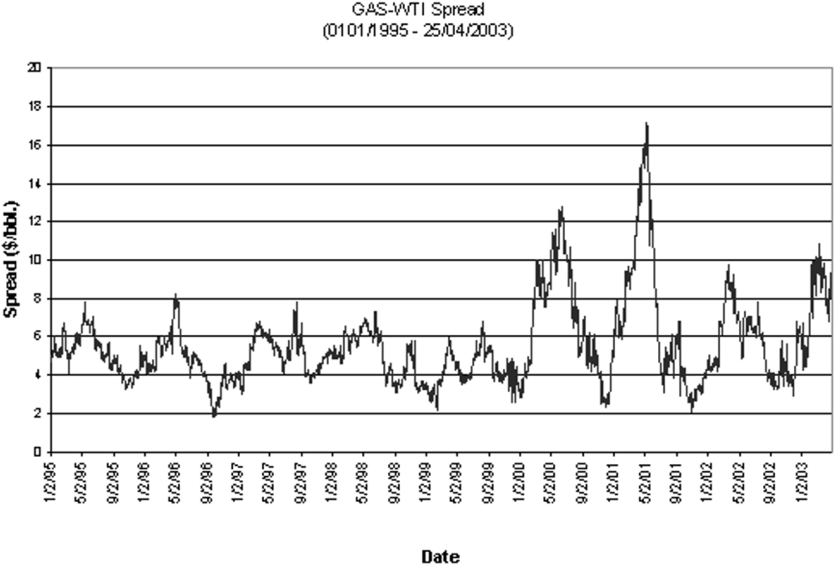

In [97]:
Image(filename='images/crack_spread.png')

# Abstract
In [1] the case is made that the crack spread exhibits asymmetry at the \\$5 dollar mark, with seemingly larger moves occuring on the upside of the long-term 'fair value' than on the downside.


The gasoline crack spread can be interpreted as the profit margin gained by processing crude oil into unleaded gasoline. It is simply the monetary difference between West Texas Intermediate crude oil and Unleaded Gasoline, both of which are traded on the New York Mercantile Exchange (NYMEX).

$$ S_{t} = GAS_t - WTI_t $$

$S_{t}$ is the price of the spread at time $t$ (in \\$ per barrel), $GAS_t$ is the price of unleaded gasoline at time $t$ (in \\$ per barrel), and $WTI_t$ is the price of West Texas Intermediate crude oil at time $t$ (in \\$ per
barrel).

## Non-linear cointegration

Cointegration was first introduced by Engle and Granger [2]. The technique is to test the null hypothesis that any combination of two series contains a unit root. If the null hypothesis is refuted and the conclusion is that a unit root does not exist, the combination of the two series is cointegrated. This is explained further below. 

As explained in the previous section, the spread may exhibit larger moves in one direction than in the other, this is known as asymmetry. Since the traditional unit root test has only one parameter for the autoregressive estimate, it assumes upside and downside moves to be identical or symmetric.

Non-linear cointegration was first introduced by Enders and Granger[3], who extended the unit root test by considering upside and downside moves separately, thus allowing for the possibility of asymmetric adjustment. 

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [107]:
from IPython.display import Image

import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.ml_approach.tar import TAR

In [108]:
wti_contract_df = pd.read_csv('./data/NonNegative_CL_forward_roll.csv').set_index('Dates')

rbob_contract_df = pd.read_csv('./data/NonNegative_RB_forward_roll.csv').set_index('Dates')

working_df = pd.concat([wti_contract_df, rbob_contract_df], axis=1)
working_df.index = pd.to_datetime(working_df.index) 
working_df.columns = ['wti', 'gasoline']

working_df.dropna(inplace=True)
working_df = working_df
working_df

,wti,gasoline
Dates,,
2006-01-03,1.034404,1.026552
2006-01-04,1.038991,1.048563
2006-01-05,1.028670,1.044253
2006-01-06,1.051933,1.060632
2006-01-09,1.040301,1.033046
...,...,...
2019-12-25,0.431366,2.160539
2019-12-26,0.435390,2.193941
2019-12-27,0.435672,2.185935


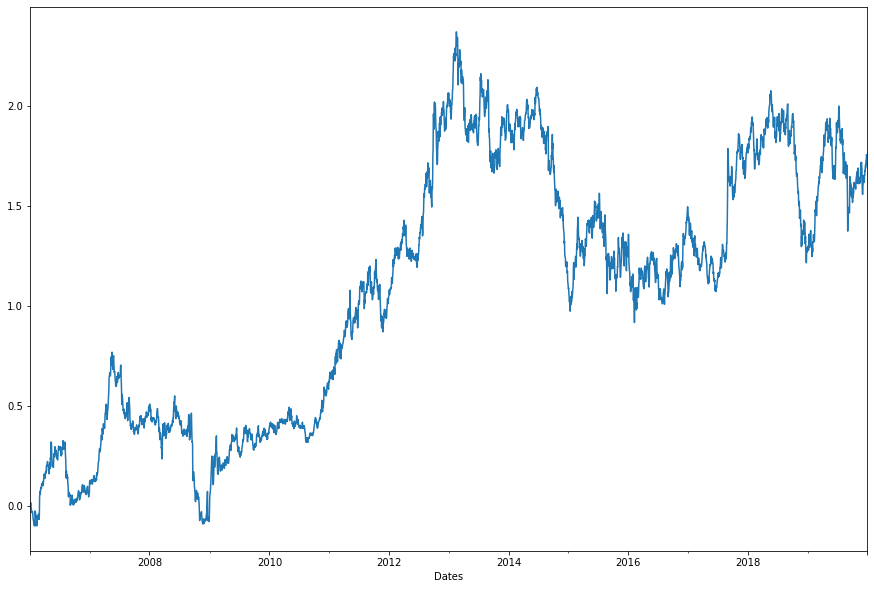

In [109]:
# logged_diff_df = np.log(working_df).pct_change().cumsum().dropna()
(working_df['gasoline'] - working_df['wti']).plot(figsize=(15,10))

Enders and Granger extend the Dickey-Fuller test to allow for the unit root hypothesis to be tested against an
alternative of asymmetric adjustment. Here, this is developed from its simplest form; consider the standard Dickey–Fuller test

$$ \Delta \mu_{t} = p \mu_{t-1} + \epsilon_t $$ 

where $\epsilon_t$ is a white noise process. The null hypothesis of $p=0$ is tested against the alternative of $p \neq 0 $. $p=0$ indicates that there is no unit root, and therefore $\mu_i$ is a stationary series. If the series $\mu_i$ are the residuals of a long-run cointegration relationship as indicated by Johansen, this
simply results in a test of the validity of the cointegrating vector (the residuals of the cointegration equation should form a stationary series).

The extension provided by Enders and Granger is to consider the upside and downside moves separately, thus allowing for the possibility of asymmetric adjustment. Following this approach;

$$ \Delta \mu_{t} = I_t p_1 \mu_{i-1} + (1 - I_t) p_2 \mu_{i-1} + \epsilon_t  $$

where $I_t$ is the zero-one ‘heaviside’ indicator function. This paper uses the following specification;

$$ I_t = \left \{ {{1, if \mu_{t-1} \geq 0} \over {0, if \mu_{t-1} < 0}} \right. $$

Enders and Granger refer to the model defined above as threshold autoregressive (TAR). The null hypothesis of symmetric adjustment is $(H_0: p_1 = p_2)$, which can be tested using the standard F-test (in this case
the Wald test), with an additional requirement that both $p_1$ and $p_2$ do not equal zero. If $p_1 \neq p_2$, cointegration between the underlying assets is non-linear.

In this case a trading model as described in Evans et al. 6 will be misspecified and equation (4) should be used to predict $\Delta \mu_t$. 

A fair value trading model has been developed from this procedure. In this model, equation (4) is used to estimate
values of $\Delta \mu_t$ from values of $\mu_{t–1}$. The values of $p_1$ and $p_2$ are estimated for the in-sample period and fixed for the out-of-sample period.

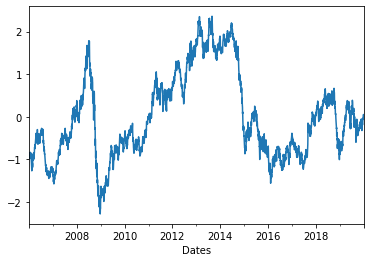

In [110]:

from arbitragelab.cointegration_approach.johansen import JohansenPortfolio

jp_df = JohansenPortfolio()

jp_df.fit(working_df[['gasoline', 'wti']])

jp_spread = jp_df.construct_mean_reverting_portfolio(working_df[['gasoline', 'wti']])
(jp_spread-jp_spread.mean()).plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              2.378
Date:                Fri, 27 Nov 2020   Prob (F-statistic):                      0.0929
Time:                        12:33:00   Log-Likelihood:                          4702.6
No. Observations:                3650   AIC:                                     -9401.
Df Residuals:                    3648   BIC:                                     -9389.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
p_1           -0.0019      0.001     -1.339      0.181      -0.005       0.001
p_2           -0.0030      0.002     -1.721      0.085      -0.006       0.000
==============================================================================
Omnibus:                      286.847   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1231.643
Skew:                          -0.267   Prob(JB):                    3.56e-268
Kurtosis:                       5.795   Cond. No.                         1.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

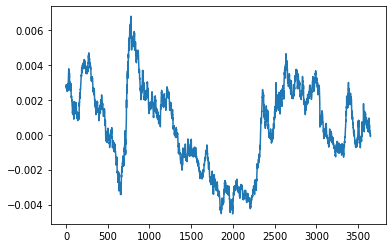

In [111]:
# model = TAR((working_df['gasoline'] - working_df['wti']), False)
# model = TAR(logged_diff_df[['gasoline', 'wti']])
model = TAR(jp_spread-jp_spread.mean(), False)
tar_results = model.fit()

tar_results.fittedvalues.plot()

tar_results.summary()

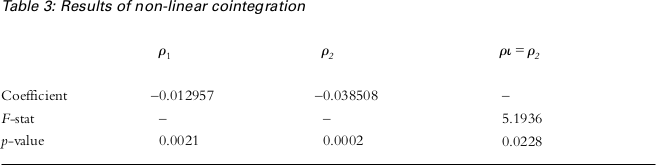

In [6]:
Image(filename='images/paper_results.png')

In [112]:
model.summary()

,p_1,p_2,p_1 = p_2
index,,,
Coefficient,-0.001921,-0.002975,NaN
F-stat,NaN,NaN,0.220525
p-value,0.180733,0.085278,0.638668


In [240]:
tar_results.fittedvalues.to_csv('./data/tar_residual_gas_wti.csv')